# MobileNet Quick Drew Example
- This notebook show you to load dataset, train mobilenet, test the model and convert to tflite for deployment on nuvoTon target board.
- Please follow the step by step and you could change the parameters for exploring the possibility.  

In [1]:
%matplotlib inline
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
import os
import sys
import ast
import re
import pathlib
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, DepthwiseConv2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, ReLU, GlobalAveragePooling2D 
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
start = dt.datetime.now()

In [7]:
#---------------------------------------------#
# Update parameters basing on your request
#---------------------------------------------#

DP_DIR = './dataset/train_simplified_all_shuffle' # The shuffled dataset       
INPUT_DIR = './dataset/train_simplified'      # The original dataset with label in file's name
BASE_IMG_SIZE = 256                           # The original image's pixel size.
NUM_CSVS = 100                                # The total shuffled fcsv files.
NUM_CATS = 340                                # The classes number

WORK_DIR = './workspace/340_all_mobilenetv2_test'      # The user defined name of work dir
MODEL_NAME = 'mobilenetv2_340_all'                # The output model's name

STEPS_P_EPOCH = 1000                           # For trining, how many steps per epoch 
INPUT_IMG_SIZE = 64                           # The size of training input image
BATCHSIZE = 530                               # For train data generator's batchsize => train data number every 1 epoch = STEPS_P_EPOCH * BATCHSIZE

EPOCHS = 2                                  # How many EPOCHS for 1 training.

MODEL_TYPE = 'mobilenetv2'                    # 'mobilenetv1', 'mobilenetv2', 'mobilenetv3'
#---------------------------------------------#

np.random.seed(seed=1987)
#tf.set_random_seed(seed=1987)
def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(INPUT_DIR)
    return sorted([f2cat(f) for f in files], key=str.lower)

def create_dirs(proj_path, model_name): 
    if not os.path.exists(proj_path):
        os.makedirs(proj_path)
        os.makedirs(os.path.join(proj_path, model_name))
        os.makedirs(os.path.join(proj_path, 'tflite'))
        os.makedirs(os.path.join(proj_path, 'checkpoint'))
        os.makedirs(os.path.join(proj_path, 'opt'))
    else:
        print('Work folder exist!')    
    return proj_path

create_dirs(WORK_DIR, MODEL_NAME)    

Work folder exist!


'./workspace/340_all_mobilenetv1_test'

## 1. Create Image Generator for training and the validation dataset

In [3]:

def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_IMG_SIZE, BASE_IMG_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255 # encode the color by line sequence 
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_IMG_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img    

def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(ast.literal_eval)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
                x /= 127.5
                x -= 1.
                x = x.astype(np.float32)
                y = keras.utils.to_categorical(df.y, num_classes=NUM_CATS)
                yield x, y                

def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x /= 127.5
    x -= 1.
    x = x.astype(np.float32)
    return x

In [4]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NUM_CSVS - 1)), nrows=2*10**3) # Use the final csvs as validation set
x_valid = df_to_image_array_xd(valid_df, INPUT_IMG_SIZE)
y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NUM_CATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(2000, 64, 64, 1) (2000, 340)
Validation array memory 0.03 GB


## 2. Start to train

- #### Load train data generator

In [5]:
train_datagen = image_generator_xd(size=INPUT_IMG_SIZE, batchsize=BATCHSIZE, ks=range(NUM_CSVS - 1))

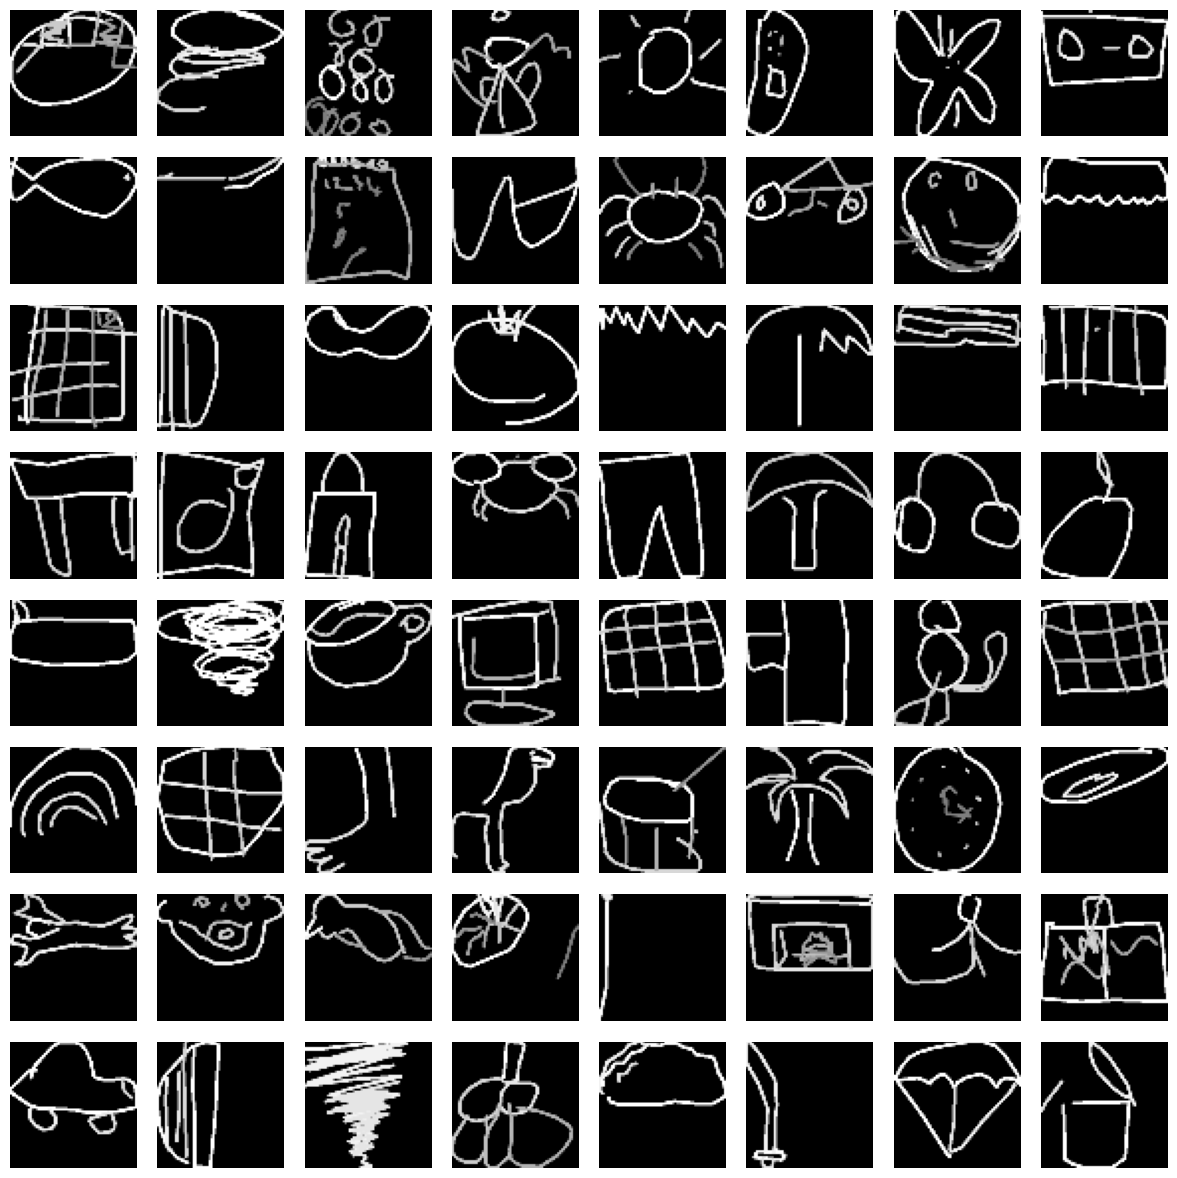

In [7]:
x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    ax.imshow(x[i, :, :, 0], cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig(os.path.join(WORK_DIR, 'bw.png'), dpi=300)
plt.show();


- #### Create the model & train strategy

In [6]:
def find_best_ckpt(dir_path, model):
      pattern = re.compile(r"\d.\d+")
      max_number = None
      # Iterate over the files in the directory
      for file in dir_path.iterdir():
          filename = file.name
          match = pattern.search(filename)
          if match:
              number_str = match.group()
              number = float(number_str)
              if max_number is None or number > max_number:
                  max_number = number
      if max_number is None:
          print("There is no best ckpt in this work project.")  
      else:
          print("Find the best ckpt:{}".format(pathlib.Path(dir_path)/(number_str+f'_best_val.ckpt')))
          model.load_weights(str(pathlib.Path(dir_path)/(number_str+f'_best_val.ckpt')))      
      
      return model

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [8]:
if MODEL_TYPE.lower() == 'mobilenetv1':
    model = tf.keras.applications.MobileNet(input_shape=(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 1),
                                             alpha=1., weights=None, classes=NUM_CATS)
elif MODEL_TYPE.lower() == 'mobilenetv2':
    model = tf.keras.applications.MobileNetV2(input_shape=(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 1), 
                                              alpha=1., weights=None, classes=NUM_CATS)
elif MODEL_TYPE.lower() == 'mobilenetv3':
    model = tf.keras.applications.MobileNetV3Small(input_shape=(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 1), 
                                                   alpha=1., weights=None, classes=NUM_CATS, minimalistic=True)
     
# Compile the model
if MODEL_TYPE.lower() == 'mobilenetv1':
    model.compile(optimizer=Adam(learning_rate=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy])
elif MODEL_TYPE.lower() == 'mobilenetv2':
    #model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',
    #          metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9, decay=4e-05), 
                  loss='categorical_crossentropy',
                  metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])

elif MODEL_TYPE.lower() == 'mobilenetv3':
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
    
# If there is a checkpt, load the previous weights.
if (pathlib.Path(WORK_DIR)/'checkpoint').exists():    
    print("Previous checkpoint folder found; loading saved weights")
    model = find_best_ckpt((pathlib.Path(WORK_DIR)/'checkpoint'), model)
else:
    print("No checkpoint found, create the workfolder.")    

print(model.summary())

Previous checkpoint folder found; loading saved weights
There is no best ckpt in this work project.
Model: "mobilenet_1.00_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        288       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 32, 32, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 32, 32, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)       288       
                                                                 
 conv_dw_1_bn (

- #### Training section
- This part is training, and it takes 1 to 2 hrs (Nvdia RTX-3090 training from scratch) to get a decent result.
- The actual training time is basing on your hardware, usage size of training dataset and model scale.


In [9]:
callbacks_chpt = tf.keras.callbacks.ModelCheckpoint(
                filepath=(os.path.join(WORK_DIR, 'checkpoint', '{val_categorical_accuracy:.3f}_best_val.ckpt')),
                save_weights_only=True, 
                monitor='val_categorical_accuracy',
                mode = 'max',
                save_best_only=True, 
                save_freq='epoch')

callbacks = [
    EarlyStopping(monitor='val_categorical_accuracy', patience=15, min_delta=0.001, mode='max'),
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, min_delta=0.005, mode='max', cooldown=3),
    callbacks_chpt
]

hists = []
hist = model.fit(
    train_datagen, steps_per_epoch=STEPS_P_EPOCH, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    #callbacks = callbacks
)
hists.append(hist)

Epoch 1/2
1000/1000 [==============================] - 124s 121ms/step - loss: 2.7563 - categorical_crossentropy: 2.7563 - categorical_accuracy: 0.3820 - val_loss: 3.1096 - val_categorical_crossentropy: 3.1096 - val_categorical_accuracy: 0.3540
Epoch 2/2
1000/1000 [==============================] - 119s 119ms/step - loss: 1.6269 - categorical_crossentropy: 1.6269 - categorical_accuracy: 0.5963 - val_loss: 1.8052 - val_categorical_crossentropy: 1.8052 - val_categorical_accuracy: 0.5630


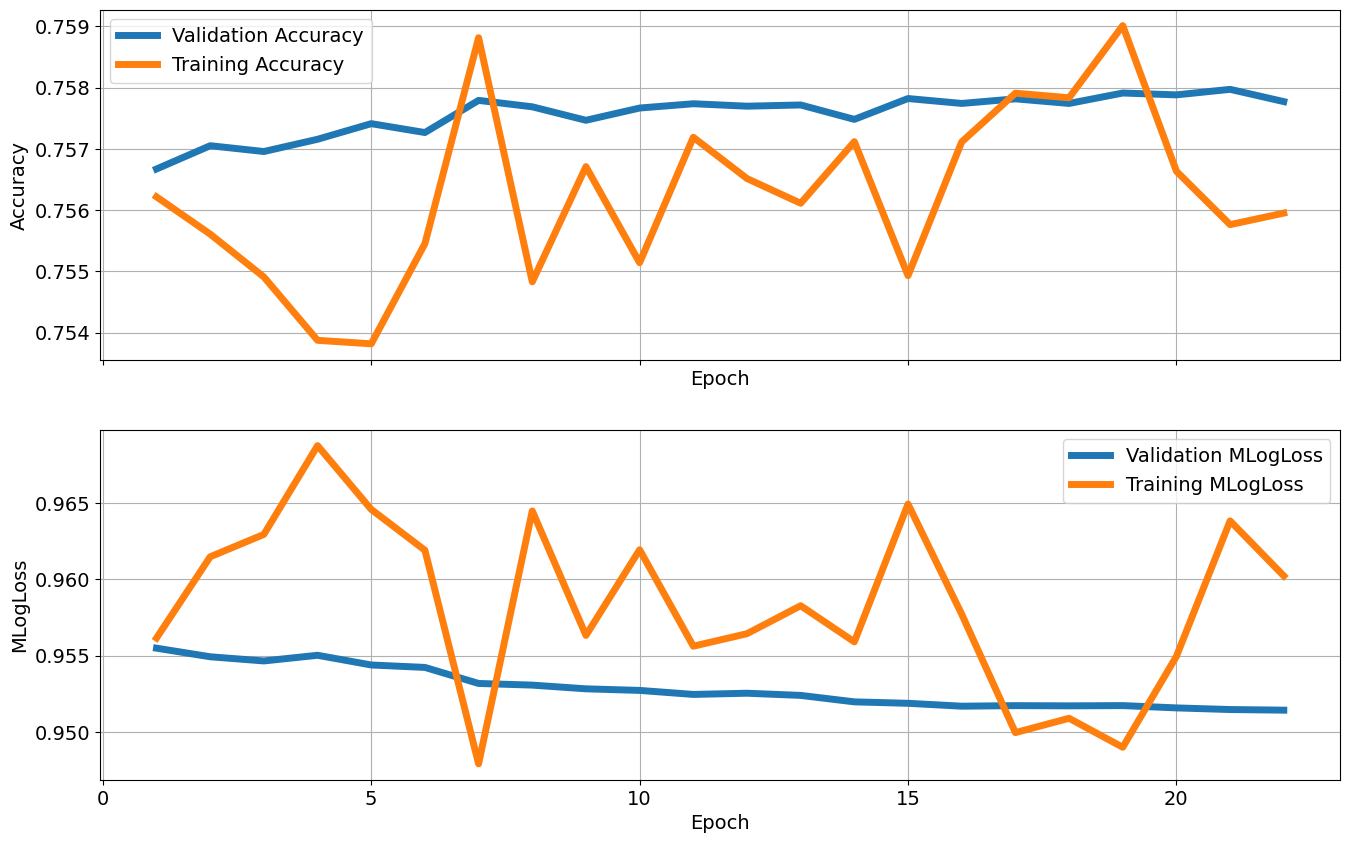

In [19]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig(os.path.join(WORK_DIR,'hist.png'), dpi=300)
plt.show();

## 3. Validation and test the model

In [10]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])


def preds2catIdx(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top3_acc( tgt, pred ):
    sc = np.mean( (pred[:,0]==tgt) | (pred[:,1]==tgt) | (pred[:,2]==tgt) )
    return sc

def top1_acc( tgt, pred ):
    sc = np.mean( (pred[:,0]==tgt))
    return sc

In [11]:
# 從checkpoint得到最好的model(val_categorical_accuracy最小)
if (pathlib.Path(WORK_DIR)/'checkpoint').exists():    
    print("Previous checkpoint folder found; loading saved weights")
    model = find_best_ckpt((pathlib.Path(WORK_DIR)/'checkpoint'), model)
else:
    print("No checkpoint found, create the workfolder.")

# Map3: 按照排名給分，第一名hit=>1, 第二名hit=>1/2, 第三名hit=>1/3 以此類推
valid_predictions = model.predict(x_valid, batch_size=128, verbose=1)
map3 = mapk(valid_df[['y']].values, preds2catIdx(valid_predictions).values)
top1 = top1_acc(valid_df[['y']].values.flatten(), preds2catIdx(valid_predictions).values)
top3 = top3_acc(valid_df[['y']].values.flatten(), preds2catIdx(valid_predictions).values)
print('Top1 Accuracy: {:.3f}'.format(top1))
print('Top3 Accuracy: {:.3f}'.format(top3))
print('Map3: {:.3f}'.format(map3))

Previous checkpoint folder found; loading saved weights
There is no best ckpt in this work project.
16/16 [==============================] - 1s 16ms/step
Top1 Accuracy: 0.563
Top3 Accuracy: 0.757
Map3: 0.647


In [12]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prunable_layer
from tensorflow_model_optimization.python.core.sparsity.keras import prune_registry

# Compute end step to finish pruning after 5 epochs.
end_epoch = 5
num_iterations_per_epoch = STEPS_P_EPOCH * BATCHSIZE
end_step =  num_iterations_per_epoch * end_epoch

# Define parameters for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.25,
                                                               final_sparsity=0.75,
                                                               begin_step=0,
                                                               end_step=end_step),
      #'pruning_policy': tfmot.sparsity.keras.PruneForLatencyOnXNNPack()
}

def apply_pruning_to_prunable_layers(layer):
    if isinstance(layer, prunable_layer.PrunableLayer) or hasattr(layer, 'get_prunable_weights') or prune_registry.PruneRegistry.supports(layer):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    print("Not Prunable: ", layer)
    return layer

model_for_pruning = tf.keras.models.clone_model(
    model,
    clone_function=apply_pruning_to_prunable_layers
)

model_for_pruning.summary()  

Model: "mobilenet_1.00_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 prune_low_magnitude_conv1 (  (None, 32, 32, 32)       578       
 PruneLowMagnitude)                                              
                                                                 
 prune_low_magnitude_conv1_b  (None, 32, 32, 32)       129       
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_conv1_r  (None, 32, 32, 32)       1         
 elu (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_conv_dw  (None, 32, 32, 32)       289       
 _1 (PruneLowMagnitude)                          

In [15]:
pruning_callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=os.path.join(WORK_DIR, 'opt')),
]

#model_for_pruning.compile(
#    loss=tf.keras.losses.CategoricalCrossentropy(),
#    optimizer='adam', metrics=['accuracy'])

model_for_pruning.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy])

#model_for_pruning.fit(train_datagen, epochs=10,
#  validation_data=(x_valid, y_valid),
#  callbacks=pruning_callbacks)

hist = model_for_pruning.fit(
    train_datagen, steps_per_epoch=STEPS_P_EPOCH, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = pruning_callbacks
)

Epoch 1/2


UnknownError: Graph execution error:

Detected at node 'mobilenet_1.00_64/prune_low_magnitude_conv1/FloorMod' defined at (most recent call last):
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\USER\AppData\Local\Temp\ipykernel_10680\759068238.py", line 17, in <cell line: 17>
      hist = model_for_pruning.fit(
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py", line 280, in call
      update_mask = utils.smart_cond(training, add_update, no_op)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\keras\utils.py", line 50, in smart_cond
      if isinstance(pred, variables.Variable):
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\keras\utils.py", line 54, in smart_cond
      pred, true_fn=true_fn, false_fn=false_fn, name=name)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py", line 268, in add_update
      with tf.control_dependencies(
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_impl.py", line 310, in conditional_mask_update
      return tf.distribute.get_replica_context().merge_call(
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_impl.py", line 307, in mask_update_distributed
      return tf.cond(maybe_update_masks(), update_distributed, no_update)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_impl.py", line 260, in maybe_update_masks
      if self._sparsity_m_by_n:
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_impl.py", line 264, in maybe_update_masks
      return self._pruning_schedule(self._step_fn())[0]
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_schedule.py", line 246, in __call__
      sparsity)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_schedule.py", line 61, in _should_prune_in_step
      is_pruning_turn = tf.math.equal(
Node: 'mobilenet_1.00_64/prune_low_magnitude_conv1/FloorMod'
Detected at node 'mobilenet_1.00_64/prune_low_magnitude_conv1/FloorMod' defined at (most recent call last):
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\USER\AppData\Local\Temp\ipykernel_10680\759068238.py", line 17, in <cell line: 17>
      hist = model_for_pruning.fit(
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py", line 280, in call
      update_mask = utils.smart_cond(training, add_update, no_op)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\keras\utils.py", line 50, in smart_cond
      if isinstance(pred, variables.Variable):
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\keras\utils.py", line 54, in smart_cond
      pred, true_fn=true_fn, false_fn=false_fn, name=name)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py", line 268, in add_update
      with tf.control_dependencies(
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_impl.py", line 310, in conditional_mask_update
      return tf.distribute.get_replica_context().merge_call(
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_impl.py", line 307, in mask_update_distributed
      return tf.cond(maybe_update_masks(), update_distributed, no_update)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_impl.py", line 260, in maybe_update_masks
      if self._sparsity_m_by_n:
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_impl.py", line 264, in maybe_update_masks
      return self._pruning_schedule(self._step_fn())[0]
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_schedule.py", line 246, in __call__
      sparsity)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_schedule.py", line 61, in _should_prune_in_step
      is_pruning_turn = tf.math.equal(
Node: 'mobilenet_1.00_64/prune_low_magnitude_conv1/FloorMod'
2 root error(s) found.
  (0) UNKNOWN:  JIT compilation failed.
	 [[{{node mobilenet_1.00_64/prune_low_magnitude_conv1/FloorMod}}]]
	 [[mobilenet_1.00_64/prune_low_magnitude_conv_pw_3_bn/assert_greater_equal/Assert/AssertGuard/pivot_f/_379/_573]]
  (1) UNKNOWN:  JIT compilation failed.
	 [[{{node mobilenet_1.00_64/prune_low_magnitude_conv1/FloorMod}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_64522]

## 4. Save the model

In [22]:
model.save(os.path.join(WORK_DIR, MODEL_NAME))
#tf.keras.models.save_model(model, os.path.join(WORK_DIR, MODEL_NAME))

INFO:tensorflow:Assets written to: ./workspace/340_all_mobilenetv2\mobilenetv2_340_all\assets


INFO:tensorflow:Assets written to: ./workspace/340_all_mobilenetv2\mobilenetv2_340_all\assets


## 5. Convert to tflite
- Include quantization and offer normal, dynamic quantization, float16 quantization and int8 quantization tflite.

In [23]:
def convert2tflite(input_keras_model, output_tflite_location, output_name, rep_dataset, rep_batch, opt_sparsity=False):
      
      def representative_dataset():
        
        for img in rep_dataset[0:rep_batch]:
            
            image = tf.expand_dims(img, axis=0)
            #image = tf.dtypes.cast(image, tf.float32) 
            yield [image]
      
      # load the keras model and the custom op.
      custom_model = input_keras_model

      # normal tflite
      converter = tf.lite.TFLiteConverter.from_keras_model(custom_model)
      tflite_model = converter.convert()
      output_location = os.path.join(output_tflite_location, (output_name + r'.tflite'))
      with open(output_location, 'wb') as f:
            f.write(tflite_model)
      print("The tflite output location: {}".format(output_location)) 
      
      # dynamic tflite
      converter = tf.lite.TFLiteConverter.from_keras_model(custom_model)
      if opt_sparsity:
          converter.optimizations = [tf.lite.Optimize.DEFAULT, tf.lite.Optimize.EXPERIMENTAL_SPARSITY]
      else:     
          converter.optimizations = [tf.lite.Optimize.DEFAULT]
      tflite_model = converter.convert()
      output_location = os.path.join(output_tflite_location, (output_name + r'_dyquant.tflite'))
      with open(output_location, 'wb') as f:
            f.write(tflite_model)
      print("The tflite output location: {}".format(output_location))
      
      # int8 Full tflite
      converter = tf.lite.TFLiteConverter.from_keras_model(custom_model)
      if opt_sparsity:
          converter.optimizations = [tf.lite.Optimize.DEFAULT, tf.lite.Optimize.EXPERIMENTAL_SPARSITY]
      else:     
          converter.optimizations = [tf.lite.Optimize.DEFAULT]
      converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.TFLITE_BUILTINS]
      converter.representative_dataset = representative_dataset
      converter.inference_input_type = tf.int8  # or tf.uint8
      converter.inference_output_type = tf.int8  # or tf.uint8
      tflite_model = converter.convert()
      output_location = os.path.join(output_tflite_location, (output_name + r'_int8quant.tflite'))
      with open(output_location, 'wb') as f:
            f.write(tflite_model)
      print("The tflite output location: {}".format(output_location)) 
      
      # f16 tflite
      converter = tf.lite.TFLiteConverter.from_keras_model(custom_model)
      if opt_sparsity:
          converter.optimizations = [tf.lite.Optimize.DEFAULT, tf.lite.Optimize.EXPERIMENTAL_SPARSITY]
      else:     
          converter.optimizations = [tf.lite.Optimize.DEFAULT]
      converter.target_spec.supported_types = [tf.float16]
      #converter.representative_dataset = representative_dataset
      tflite_model = converter.convert()
      output_location = os.path.join(output_tflite_location, (output_name + r'_f16quant.tflite'))
      with open(output_location, 'wb') as f:
            f.write(tflite_model)
      print("The tflite output location: {}".format(output_location))

In [25]:
# load the keras model and the custom op.
model = keras.models.load_model(os.path.join(WORK_DIR, MODEL_NAME), MODEL_NAME, compile=False, custom_objects={'top_3_accuracy':top_3_accuracy})

convert2tflite(model, os.path.join(WORK_DIR, 'tflite'), x_valid, 256)

INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpo6kgoo6h\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpo6kgoo6h\assets


The tflite output location: ./workspace/340_all_mobilenetv2\tflite\mobilenetv2_340_all.tflite


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp93m29nus\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp93m29nus\assets


The tflite output location: ./workspace/340_all_mobilenetv2\tflite\mobilenetv2_340_all_dyquant.tflite


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpsi51ujcs\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpsi51ujcs\assets
c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


The tflite output location: ./workspace/340_all_mobilenetv2\tflite\mobilenetv2_340_all_int8quant.tflite


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp7v02rojh\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp7v02rojh\assets


The tflite output location: ./workspace/340_all_mobilenetv2\tflite\mobilenetv2_340_all_f16quant.tflite


- #### Test the tflite to make sure the accuracy. 

In [25]:
from tqdm import tqdm
def tflite_inference(rep_dataset, rep_dataset_y, tflite_path, batch_N):
      """Call forwards pass of TFLite file and returns the result.
  
      Args:
          input_data: Input data to use on forward pass.
          tflite_path: Path to TFLite file to run.
  
      Returns:
          Output from inference.
      """

      interpreter = tf.lite.Interpreter(model_path=tflite_path)
      
  
      input_details = interpreter.get_input_details()
      output_details = interpreter.get_output_details()
  
      input_dtype = input_details[0]["dtype"]
      output_dtype = output_details[0]["dtype"]

      input_shape = input_details[0]['shape']
      output_shape = output_details[0]['shape']
      interpreter.resize_tensor_input(input_details[0]['index'], [batch_N, input_shape[1], input_shape[2], input_shape[3]])
      interpreter.resize_tensor_input(output_details[0]['index'], [batch_N, output_shape[1]])

      interpreter.allocate_tensors()
  
      # Check if the input/output type is quantized,
      # set scale and zero-point accordingly
      if input_dtype == np.int8:
          input_scale, input_zero_point = input_details[0]["quantization"]
          rep_dataset = np.round(rep_dataset/input_scale + input_zero_point)

      else:
          #input_scale, input_zero_point = 1, 0
          input_scale, input_zero_point = input_details[0]["quantization"]
  
      if input_dtype == np.int8:
          output_scale, output_zero_point = output_details[0]["quantization"]
      else:
          output_scale, output_zero_point = 1, 0
      
      # skip the final set < batch_N, bcs the input/output tensor are fix. 
      loop_num = (int)(np.floor(len(rep_dataset)/batch_N))  
      
      acy_all  = 0
      acy_top3 = 0
      for i in tqdm(range(loop_num)):
          #if i == (loop_num - 1):
          #    input_batch = rep_dataset[i*batch_N:-1]
          #else:
          input_batch = rep_dataset[i*batch_N:(i+1)*batch_N]

          interpreter.set_tensor(input_details[0]['index'], tf.cast(input_batch, input_dtype))
          interpreter.invoke()
          output_data = interpreter.get_tensor(output_details[0]['index'])
          output_data = output_scale * (output_data.astype(np.float32) - output_zero_point)
          #print(preds2catIdx(output_data).shape)
          acy_all += top1_acc(valid_df[['y']][i*batch_N:(i+1)*batch_N].values.flatten(), preds2catIdx(output_data).values)
          acy_top3 += top3_acc(rep_dataset_y[['y']][i*batch_N:(i+1)*batch_N].values.flatten(), preds2catIdx(output_data).values)
          #print('Top3 Accuracy: {:.3f}'.format(top3))

      return   acy_all/loop_num, acy_top3/loop_num


In [26]:
#top1, top3 = tflite_inference(x_valid[0:64], valid_df[['y']][0:64], os.path.join(WORK_DIR, 'tflite', (MODEL_NAME + r'_dyquant.tflite')), 32) 
top1, top3 = tflite_inference(x_valid[0:1000], valid_df[['y']][0:1000], os.path.join(WORK_DIR, 'tflite', (MODEL_NAME + r'_int8quant.tflite')), 32) 

100%|██████████| 31/31 [02:27<00:00,  4.77s/it]


In [27]:
print('Top1 Accuracy: {:.3f}'.format(top1))
print('Top3 Accuracy: {:.3f}'.format(top3))  

Top1 Accuracy: 0.801
Top3 Accuracy: 0.935


## 6. TensorFlow model optimization (Optional)

#### Weight Pruning
- [TF guide pruning](https://www.tensorflow.org/model_optimization/guide/pruning)

1. Load and show the result of original model

In [28]:
import tensorflow_model_optimization as tfmot

# load the keras model and the custom op.
ori_model = keras.models.load_model(os.path.join(WORK_DIR, MODEL_NAME), custom_objects={'top_3_accuracy':top_3_accuracy})

# Create working dir
logdir = os.path.join(WORK_DIR, 'opt', 'pruning')
if not os.path.exists(logdir):
    os.makedirs(logdir)
else:
    print('Work folder exist: {}'.format(logdir))   

In [48]:
ori_model = model

# Map3: 按照排名給分，第一名hit=>1, 第二名hit=>1/2, 第三名hit=>1/3 以此類推
print('Original model test accuracy:')
valid_predictions = ori_model.predict(x_valid, batch_size=128, verbose=1)
map3 = mapk(valid_df[['y']].values, preds2catIdx(valid_predictions).values)
top1 = top1_acc(valid_df[['y']].values.flatten(), preds2catIdx(valid_predictions).values)
top3 = top3_acc(valid_df[['y']].values.flatten(), preds2catIdx(valid_predictions).values)
print('Top1 Accuracy: {:.3f}'.format(top1))
print('Top3 Accuracy: {:.3f}'.format(top3))
print('Map3: {:.3f}'.format(map3))

Original model test accuracy:
1563/1563 [==============================] - 8s 5ms/step
Top1 Accuracy: 0.797
Top3 Accuracy: 0.923
Map3: 0.852


In [49]:
import tempfile

_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Saved baseline model to: C:\Users\USER\AppData\Local\Temp\tmp_c2t59ud.h5


In [53]:
ori_model = keras.models.load_model(keras_file, custom_objects={'top_3_accuracy':top_3_accuracy})


2. Build the sparse model

In [51]:

# Compute end step to finish pruning after 5 epochs.
end_epoch = 5
num_iterations_per_epoch = STEPS_P_EPOCH * BATCHSIZE
end_step =  num_iterations_per_epoch * end_epoch

# Define parameters for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.25,
                                                               final_sparsity=0.75,
                                                               begin_step=0,
                                                               end_step=end_step),
      #'pruning_policy': tfmot.sparsity.keras.PruneForLatencyOnXNNPack()
}

# Try to apply pruning wrapper with pruning policy parameter.
try:
  model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(ori_model, **pruning_params)
except ValueError as e:
  print(e)

model_for_pruning.summary()  

Model: "mobilenet_1.00_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 prune_low_magnitude_conv1 (  (None, 32, 32, 32)       578       
 PruneLowMagnitude)                                              
                                                                 
 prune_low_magnitude_conv1_b  (None, 32, 32, 32)       129       
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_conv1_r  (None, 32, 32, 32)       1         
 elu (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_conv_dw  (None, 32, 32, 32)       289       
 _1 (PruneLowMagnitude)                          

In [ ]:
from tensorflow_model_optimization.python.core.sparsity.keras import prunable_layer
from tensorflow_model_optimization.python.core.sparsity.keras import prune_registry

# Define parameters for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.25,
                                                               final_sparsity=0.75,
                                                               begin_step=0,
                                                               end_step=end_step),
      #'pruning_policy': tfmot.sparsity.keras.PruneForLatencyOnXNNPack()
}

def apply_pruning_to_prunable_layers(layer):
    if isinstance(layer, prunable_layer.PrunableLayer) or hasattr(layer, 'get_prunable_weights') or prune_registry.PruneRegistry.supports(layer):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    print("Not Prunable: ", layer)
    return layer

model_for_pruning = tf.keras.models.clone_model(
    ori_model,
    clone_function=apply_pruning_to_prunable_layers
)

3. Fine tune the sparse model

In [52]:
pruning_callbacks = [
  EarlyStopping(monitor='val_categorical_accuracy', patience=15, min_delta=0.001, mode='max'),
  ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, min_delta=0.005, mode='max', cooldown=3),  
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

#model_for_pruning.compile(
#    loss=tf.keras.losses.CategoricalCrossentropy(),
#    optimizer='adam', metrics=['accuracy'])

model_for_pruning.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])

#model_for_pruning.fit(train_datagen, epochs=10,
#  validation_data=(x_valid, y_valid),
#  callbacks=pruning_callbacks)

hist = model_for_pruning.fit(
    train_datagen, steps_per_epoch=STEPS_P_EPOCH, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = pruning_callbacks
)

UnknownError: Graph execution error:

Detected at node 'mobilenet_1.00_64/prune_low_magnitude_conv1/FloorMod' defined at (most recent call last):
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\USER\AppData\Local\Temp\ipykernel_10924\3644943585.py", line 19, in <cell line: 19>
      hist = model_for_pruning.fit(
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py", line 280, in call
      update_mask = utils.smart_cond(training, add_update, no_op)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\keras\utils.py", line 50, in smart_cond
      if isinstance(pred, variables.Variable):
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\keras\utils.py", line 54, in smart_cond
      pred, true_fn=true_fn, false_fn=false_fn, name=name)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py", line 268, in add_update
      with tf.control_dependencies(
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_impl.py", line 310, in conditional_mask_update
      return tf.distribute.get_replica_context().merge_call(
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_impl.py", line 307, in mask_update_distributed
      return tf.cond(maybe_update_masks(), update_distributed, no_update)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_impl.py", line 260, in maybe_update_masks
      if self._sparsity_m_by_n:
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_impl.py", line 264, in maybe_update_masks
      return self._pruning_schedule(self._step_fn())[0]
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_schedule.py", line 246, in __call__
      sparsity)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_schedule.py", line 61, in _should_prune_in_step
      is_pruning_turn = tf.math.equal(
Node: 'mobilenet_1.00_64/prune_low_magnitude_conv1/FloorMod'
Detected at node 'mobilenet_1.00_64/prune_low_magnitude_conv1/FloorMod' defined at (most recent call last):
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\USER\AppData\Local\Temp\ipykernel_10924\3644943585.py", line 19, in <cell line: 19>
      hist = model_for_pruning.fit(
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py", line 280, in call
      update_mask = utils.smart_cond(training, add_update, no_op)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\keras\utils.py", line 50, in smart_cond
      if isinstance(pred, variables.Variable):
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\keras\utils.py", line 54, in smart_cond
      pred, true_fn=true_fn, false_fn=false_fn, name=name)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_wrapper.py", line 268, in add_update
      with tf.control_dependencies(
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_impl.py", line 310, in conditional_mask_update
      return tf.distribute.get_replica_context().merge_call(
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_impl.py", line 307, in mask_update_distributed
      return tf.cond(maybe_update_masks(), update_distributed, no_update)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_impl.py", line 260, in maybe_update_masks
      if self._sparsity_m_by_n:
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_impl.py", line 264, in maybe_update_masks
      return self._pruning_schedule(self._step_fn())[0]
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_schedule.py", line 246, in __call__
      sparsity)
    File "c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow_model_optimization\python\core\sparsity\keras\pruning_schedule.py", line 61, in _should_prune_in_step
      is_pruning_turn = tf.math.equal(
Node: 'mobilenet_1.00_64/prune_low_magnitude_conv1/FloorMod'
2 root error(s) found.
  (0) UNKNOWN:  JIT compilation failed.
	 [[{{node mobilenet_1.00_64/prune_low_magnitude_conv1/FloorMod}}]]
	 [[mobilenet_1.00_64/prune_low_magnitude_conv_dw_9_relu/assert_greater_equal/Assert/AssertGuard/pivot_f/_1047/_1257]]
  (1) UNKNOWN:  JIT compilation failed.
	 [[{{node mobilenet_1.00_64/prune_low_magnitude_conv1/FloorMod}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_3279496]

In [ ]:
# Evaluate the dense model.
print('Pruned model test accuracy:')
pruning_valid_predictions = model_for_pruning.predict(x_valid, batch_size=128, verbose=1)
map3 = mapk(valid_df[['y']].values, preds2catIdx(pruning_valid_predictions).values)
top1 = top1_acc(valid_df[['y']].values.flatten(), preds2catIdx(pruning_valid_predictions).values)
top3 = top3_acc(valid_df[['y']].values.flatten(), preds2catIdx(pruning_valid_predictions).values)
print('Top1 Accuracy: {:.3f}'.format(top1))
print('Top3 Accuracy: {:.3f}'.format(top3))
print('Map3: {:.3f}'.format(map3))

4. Convert to TFLite

In [ ]:
convert2tflite(pruning_valid_predictions, logdir, (MODEL_NAME+r'pruned'), x_valid, 256, opt_sparsity=True)